<a href="https://colab.research.google.com/github/KumudaBG/DeepLearning-Assignment3/blob/main/b1_pytorch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3-dimensional inputs , 2-D output

In [31]:
!python --version

Python 3.7.10


In [32]:
!pip list | grep tensor

tensorboard                   2.4.1         
tensorboard-plugin-wit        1.8.0         
tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.28.0        
tensorflow-probability        0.12.1        


In [33]:
!pip list | grep torch

torch                         1.8.0+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.0         
torchvision                   0.9.0+cu101   


In [34]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [35]:
import torch

n = 270
d = 3
x = torch.FloatTensor(n, d).uniform_(-1, 1)
weights_true = torch.tensor([[5,1,2],[2,2,1]]).float()
weights_true = torch.transpose(weights_true,0,1)
bias_true= torch.tensor([2,1])
y_true = (x ** 2) @ weights_true+ x @ weights_true + bias_true.T
print(f'y: {y_true.shape}')
print(y_true)

y: torch.Size([270, 2])
tensor([[ 5.0653,  3.7342],
        [ 4.0132,  2.1527],
        [ 5.7609,  2.7614],
        [ 6.0981,  4.2448],
        [ 7.0010,  2.7737],
        [ 0.3068,  0.1231],
        [ 7.1159,  2.7305],
        [ 3.9358,  3.4830],
        [14.8612,  8.1750],
        [ 0.5674,  0.0838],
        [ 0.2467, -0.0495],
        [ 1.4890,  0.8725],
        [ 2.7350,  3.3138],
        [ 2.4804,  0.7653],
        [10.5955,  5.1890],
        [ 0.7994,  0.7777],
        [ 7.5317,  4.5980],
        [ 6.3070,  5.3564],
        [ 4.2083,  4.4078],
        [ 2.1348,  3.7950],
        [ 3.2992,  2.6890],
        [ 2.3183,  0.7634],
        [ 0.6726,  0.1414],
        [ 2.1377,  0.9132],
        [ 0.4136,  0.0356],
        [ 7.0173,  2.7225],
        [ 2.6308,  4.3664],
        [ 4.5315,  2.0102],
        [ 3.3568,  4.1590],
        [ 6.7725,  2.5291],
        [ 4.3028,  2.0231],
        [12.0442,  5.1378],
        [ 3.0009,  0.9906],
        [ 6.8587,  3.1757],
        [ 5.7071,  2.910

#Visualization

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

In [37]:
import plotly.graph_objects as pltgo
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

In [38]:
X = TSNE(n_components=2).fit_transform(x)
Y = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X,Y)

#Loss function-Mean Square Error/MSE

In [39]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

#Relu Activation Function

In [40]:
class Relu:
    def __call__(self, input_):
      self.input_ = input_
      self.output = torch.clamp(self.input_, min=0, out=None)
      return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient 
      return self.input_gradient

In [41]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden)
    self.bias = torch.zeros(num_hidden,)
  
  def __call__(self, x):
    self.x = x
    return torch.mm(x, self.weights) + self.bias

  def backward(self, gradient):
    self.weights_gradient = torch.mm(torch.transpose(self.x,0,1), gradient)
    self.bias_gradient = gradient.sum(0)
    self.x_gradient = torch.mm(gradient, torch.transpose(self.weights,0,1))
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

#Neural network Model

In [42]:
import torch
from typing import Callable
class Model:
  def __init__(self, input_dim, num_hidden=12):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden, 12) # Pick 12 as number of neurons in hidden layer
    self.relu2 = Relu()
    self.linear3 = Linear(12,2)
  
  # Forward pass
  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

In [43]:
from typing import Callable

def torch_fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

In [45]:
model = Model(d, 10)
loss=MSE()
torch_fit(x, y_true, model=model, loss=loss, lr=0.0035, num_epochs=1000)

x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

Epoch 0, loss 116.28942108154297
Epoch 1, loss 11.27899169921875
Epoch 2, loss 10.711583137512207
Epoch 3, loss 10.181389808654785
Epoch 4, loss 9.651780128479004
Epoch 5, loss 9.092987060546875
Epoch 6, loss 8.52647590637207
Epoch 7, loss 7.9604692459106445
Epoch 8, loss 7.413628101348877
Epoch 9, loss 6.897273540496826
Epoch 10, loss 6.403738975524902
Epoch 11, loss 5.933322906494141
Epoch 12, loss 5.495833396911621
Epoch 13, loss 5.094821929931641
Epoch 14, loss 4.725870609283447
Epoch 15, loss 4.388563632965088
Epoch 16, loss 4.082068920135498
Epoch 17, loss 3.8048040866851807
Epoch 18, loss 3.5506463050842285
Epoch 19, loss 3.320103168487549
Epoch 20, loss 3.110051393508911
Epoch 21, loss 2.9179515838623047
Epoch 22, loss 2.743311882019043
Epoch 23, loss 2.5841622352600098
Epoch 24, loss 2.4388060569763184
Epoch 25, loss 2.3067800998687744
Epoch 26, loss 2.1870381832122803
Epoch 27, loss 2.078115701675415
Epoch 28, loss 1.9790667295455933
Epoch 29, loss 1.888826847076416
Epoch 30,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



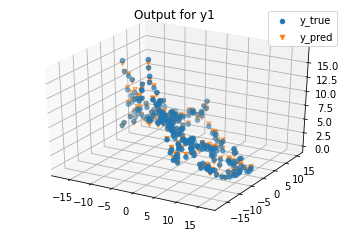

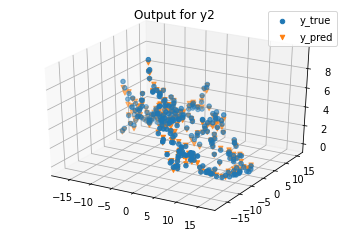

In [47]:
y_pred=model(x).detach().numpy()
plot_3d('Output for y1', x, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2', x, y_true[:,1], y_pred[:,1])

In [48]:
X_plot = TSNE(n_components=2).fit_transform(x)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)